# Importing Libraries

__NOTE:__ Training cell output is cleared from notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Building Artificial Neural Network (Very Basic)

## Hyperparameters

In [4]:
batch_size = 64
learning_rate = 1e-3
epochs = 150

## Downloading and preprocessing data

In [5]:
base_folder = './data'
fashion_mnist_train = datasets.FashionMNIST(base_folder, download = True, train = True)
fashion_mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [6]:
train_images, train_labels = fashion_mnist_train.data, fashion_mnist_train.targets
print(f"Number of Training Images: {len(train_images)}")
print(train_images.shape, train_labels.shape)

Number of Training Images: 60000
torch.Size([60000, 28, 28]) torch.Size([60000])


In [7]:
print(f"Classes present in dataset: \n{fashion_mnist_train.classes}")

Classes present in dataset: 
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


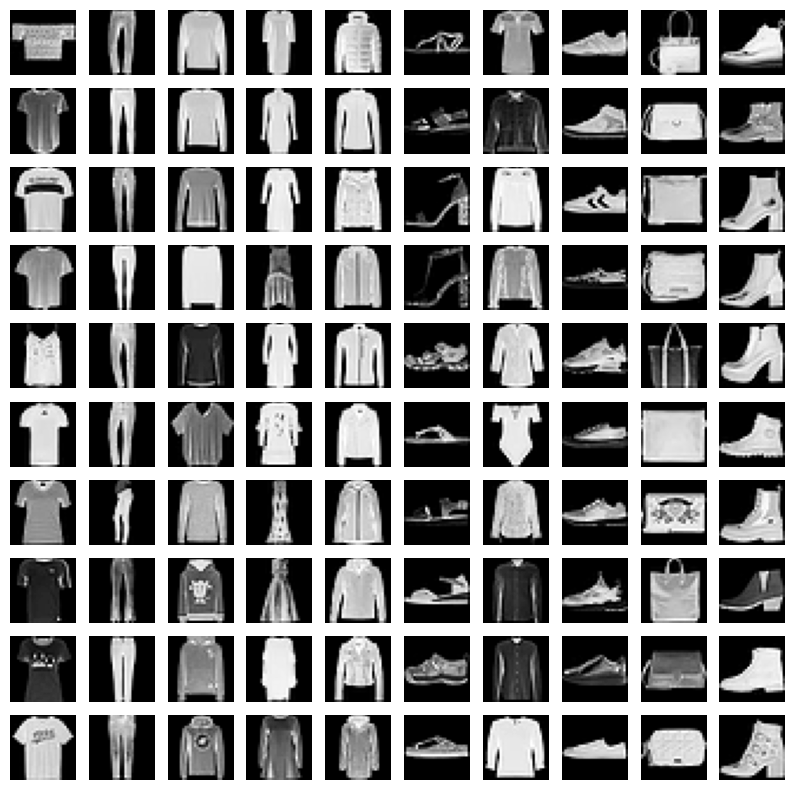

In [8]:
# Visualizing Data
unique_classes = np.unique(train_labels)
rows, cols = 10, len(unique_classes)
fig, axes = plt.subplots(rows, cols, figsize = (10,10))
i = 0
for _class in unique_classes:
    label_idx = np.where(train_labels == _class)[0]
    random_per_class = label_idx[np.random.choice(label_idx.shape[0], 10, replace = False)]
    for idx in random_per_class:
        img = train_images[idx]
        axes[i%10, i//10].imshow(img, cmap = 'gray')
        axes[i%10, i//10].axis('off')
        i+=1

In [9]:
fashion_mnist_valid = datasets.FashionMNIST(base_folder, download = True, train = False)
fashion_mnist_valid

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [10]:
valid_images, valid_labels = fashion_mnist_valid.data, fashion_mnist_valid.targets
print(f"Number of Valid Images: {len(valid_images)}")
print(valid_images.shape, valid_labels.shape)

Number of Valid Images: 10000
torch.Size([10000, 28, 28]) torch.Size([10000])


## Helper functions for training

In [11]:
class FMNISTDataset(Dataset):
    def __init__(self, imgs, lbls):
        # Flattening image
        self.imgs = imgs
        self.lbls = lbls
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img, lbl = self.imgs[idx], self.lbls[idx]
        
        # Normalize input image to be in between 0-1
        img = img / 255.
        
        # Flattening 2D image into a vector
        img = img.view(-1)
        return img, lbl

In [12]:
def get_data(bs = 64):
    train_data = FMNISTDataset(train_images, train_labels)
    trainloader = DataLoader(train_data, batch_size = bs, shuffle = True)
    valid_data = FMNISTDataset(valid_images, valid_labels)
    validloader = DataLoader(valid_data, batch_size = bs)
    return trainloader, validloader

def build_model(lr = 1e-03):
    # Creating simple model with 1 hidden layer
    model = nn.Sequential(nn.Linear(28*28, 1000),
                         nn.ReLU(),
                         nn.Linear(1000, 10))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr)
    return model, criterion, optimizer

def train_batch(imgs, lbls, model, criterion, optimizer, valid = False):
    optimizer.zero_grad()
    imgs, lbls, model = imgs.to(device), lbls.to(device), model.to(device)
    out = model(imgs)
    batch_loss = criterion(out, lbls)
    if not valid:
        batch_loss.backward()
        optimizer.step()
    return batch_loss.item()

def no_of_correct(imgs, lbls, model):
    imgs, lbls, model = imgs.to(device), lbls.to(device), model.to(device)
    with torch.no_grad():
        model.eval()
        out = model(imgs)
        _, preds= out.max(-1)
        correct_preds = preds == lbls
        return correct_preds.cpu().numpy().sum(), len(lbls)

In [13]:
def train(epochs, learning_rate):
    trainloader, validloader = get_data(batch_size)
    model, criterion, optimizer = build_model(learning_rate)
    train_accuracies, valid_accuracies = [], []
    train_losses, valid_losses = [], []
    for epoch in range(epochs):
        print(f"{'*'*10} EPOCH {epoch:2}/{epochs-1} {'*'*10}")
        batch_loss = 0.0
        model.train()
        for imgs, lbls in trainloader:
            batch_loss += train_batch(imgs, lbls, model, criterion, optimizer)

        total_correct = 0
        total = 0
        for imgs, lbls in trainloader:
            batch_correct, batch_total = no_of_correct(imgs, lbls, model)
            total_correct += batch_correct
            total += batch_total

        epoch_train_acc = total_correct/total
        train_accuracies.append(epoch_train_acc)
        epoch_train_loss = batch_loss / len(trainloader)
        train_losses.append(epoch_train_loss)

        # Calculating for Valid data
        batch_loss = 0.0
        total_correct = 0
        total = 0
        for imgs, lbls in validloader:
            batch_loss += train_batch(imgs, lbls, model, criterion, optimizer, valid = True)
            batch_correct, batch_total = no_of_correct(imgs, lbls, model)
            total_correct += batch_correct
            total += batch_total

        epoch_valid_loss = batch_loss / len(validloader)
        epoch_valid_acc = total_correct / total
        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_acc)

        print(f'''{"#"*33}
Train Loss: {epoch_train_loss:5.3f}, Train Accuracy: {epoch_train_acc*100:5.2f}
Valid Loss: {epoch_valid_loss:5.3f}, Valid Accuracy: {epoch_valid_acc*100:5.2f}
{"#"*33}''')
        
    return train_losses, train_accuracies, valid_losses, valid_accuracies

## Training

In [ ]:
train_losses, train_accuracies, valid_losses, valid_accuracies = train(epochs, learning_rate)

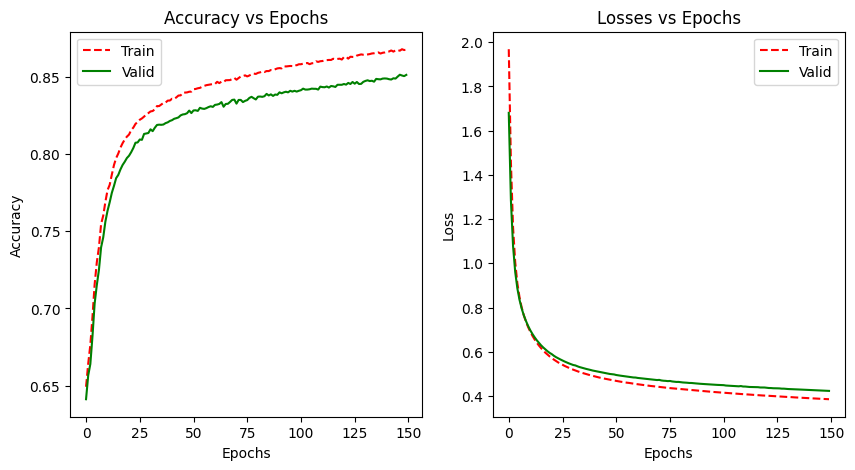

In [15]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

# Hyperparams tuning

## 1.) Changing Optimizer

In [16]:
def build_model(lr = 1e-03):
    # Creating simple model with 1 hidden layer
    model = nn.Sequential(nn.Linear(28*28, 1000),
                         nn.ReLU(),
                         nn.Linear(1000, 10))
    criterion = nn.CrossEntropyLoss()
    
    # Made changes in optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr)
    return model, criterion, optimizer

In [ ]:
train_losses, train_accuracies, valid_losses, valid_accuracies = train(epochs, learning_rate)

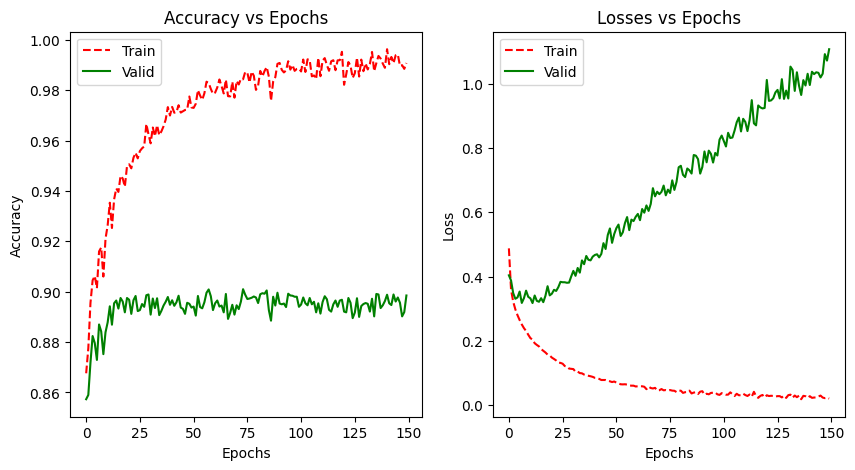

In [18]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

Note: Overfitting occurs due to running for so many epochs. Also valid accuracy is good compared to using sgd.

## 2.) Changing learning rate

### Learning Rate = 0.01

In [19]:
epochs = 100
learning_rate = 1e-02
train_losses, train_accuracies, valid_losses, valid_accuracies = train(epochs, learning_rate)

********** EPOCH  0/99 **********
#################################
Train Loss: 0.526, Train Accuracy: 81.49
Valid Loss: 0.544, Valid Accuracy: 79.62
#################################
********** EPOCH  1/99 **********
#################################
Train Loss: 0.413, Train Accuracy: 86.41
Valid Loss: 0.428, Valid Accuracy: 84.72
#################################
********** EPOCH  2/99 **********
#################################
Train Loss: 0.381, Train Accuracy: 85.91
Valid Loss: 0.440, Valid Accuracy: 83.98
#################################
********** EPOCH  3/99 **********
#################################
Train Loss: 0.374, Train Accuracy: 87.35
Valid Loss: 0.409, Valid Accuracy: 85.46
#################################
********** EPOCH  4/99 **********
#################################
Train Loss: 0.361, Train Accuracy: 87.26
Valid Loss: 0.423, Valid Accuracy: 84.88
#################################
********** EPOCH  5/99 **********
#################################
Train Loss: 

#################################
Train Loss: 0.271, Train Accuracy: 90.50
Valid Loss: 0.555, Valid Accuracy: 86.12
#################################
********** EPOCH 46/99 **********
#################################
Train Loss: 0.265, Train Accuracy: 90.10
Valid Loss: 0.530, Valid Accuracy: 85.62
#################################
********** EPOCH 47/99 **********
#################################
Train Loss: 0.263, Train Accuracy: 90.94
Valid Loss: 0.536, Valid Accuracy: 86.38
#################################
********** EPOCH 48/99 **********
#################################
Train Loss: 0.263, Train Accuracy: 89.26
Valid Loss: 0.583, Valid Accuracy: 84.16
#################################
********** EPOCH 49/99 **********
#################################
Train Loss: 0.268, Train Accuracy: 90.60
Valid Loss: 0.568, Valid Accuracy: 85.98
#################################
********** EPOCH 50/99 **********
#################################
Train Loss: 0.260, Train Accuracy: 90.73
Valid

#################################
Train Loss: 0.248, Train Accuracy: 91.45
Valid Loss: 0.705, Valid Accuracy: 86.08
#################################
********** EPOCH 91/99 **********
#################################
Train Loss: 0.243, Train Accuracy: 91.31
Valid Loss: 0.685, Valid Accuracy: 85.88
#################################
********** EPOCH 92/99 **********
#################################
Train Loss: 0.241, Train Accuracy: 91.38
Valid Loss: 0.695, Valid Accuracy: 85.74
#################################
********** EPOCH 93/99 **********
#################################
Train Loss: 0.242, Train Accuracy: 91.76
Valid Loss: 0.680, Valid Accuracy: 86.06
#################################
********** EPOCH 94/99 **********
#################################
Train Loss: 0.237, Train Accuracy: 91.39
Valid Loss: 0.725, Valid Accuracy: 85.85
#################################
********** EPOCH 95/99 **********
#################################
Train Loss: 0.240, Train Accuracy: 91.50
Valid

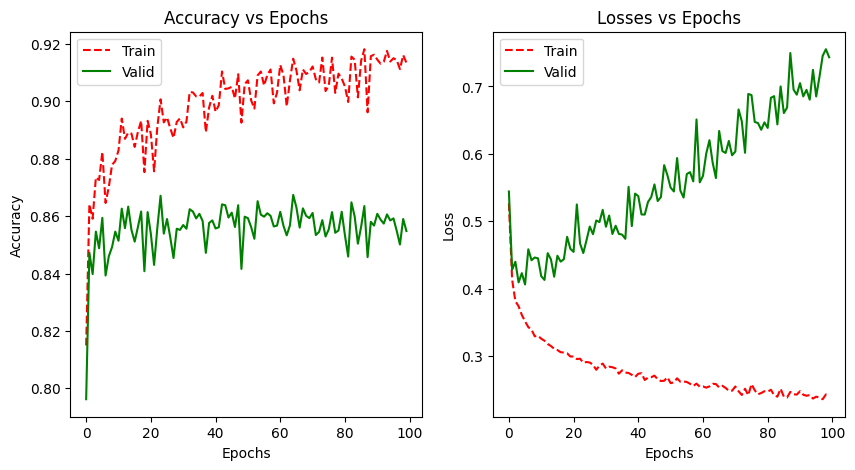

In [20]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

### Learning Rate = 0.0001

In [22]:
epochs = 100
learning_rate = 1e-04
train_losses, train_accuracies, valid_losses, valid_accuracies = train(epochs, learning_rate)

********** EPOCH  0/99 **********
#################################
Train Loss: 0.680, Train Accuracy: 83.78
Valid Loss: 0.507, Valid Accuracy: 82.40
#################################
********** EPOCH  1/99 **********
#################################
Train Loss: 0.454, Train Accuracy: 85.22
Valid Loss: 0.457, Valid Accuracy: 83.82
#################################
********** EPOCH  2/99 **********
#################################
Train Loss: 0.411, Train Accuracy: 86.38
Valid Loss: 0.427, Valid Accuracy: 85.11
#################################
********** EPOCH  3/99 **********
#################################
Train Loss: 0.384, Train Accuracy: 86.99
Valid Loss: 0.410, Valid Accuracy: 85.30
#################################
********** EPOCH  4/99 **********
#################################
Train Loss: 0.364, Train Accuracy: 87.79
Valid Loss: 0.394, Valid Accuracy: 86.30
#################################
********** EPOCH  5/99 **********
#################################
Train Loss: 

#################################
Train Loss: 0.143, Train Accuracy: 95.58
Valid Loss: 0.301, Valid Accuracy: 89.74
#################################
********** EPOCH 46/99 **********
#################################
Train Loss: 0.139, Train Accuracy: 95.71
Valid Loss: 0.301, Valid Accuracy: 89.85
#################################
********** EPOCH 47/99 **********
#################################
Train Loss: 0.137, Train Accuracy: 95.62
Valid Loss: 0.307, Valid Accuracy: 89.79
#################################
********** EPOCH 48/99 **********
#################################
Train Loss: 0.133, Train Accuracy: 95.55
Valid Loss: 0.311, Valid Accuracy: 89.61
#################################
********** EPOCH 49/99 **********
#################################
Train Loss: 0.132, Train Accuracy: 95.77
Valid Loss: 0.312, Valid Accuracy: 89.83
#################################
********** EPOCH 50/99 **********
#################################
Train Loss: 0.128, Train Accuracy: 95.91
Valid

#################################
Train Loss: 0.054, Train Accuracy: 98.45
Valid Loss: 0.369, Valid Accuracy: 89.84
#################################
********** EPOCH 91/99 **********
#################################
Train Loss: 0.054, Train Accuracy: 98.77
Valid Loss: 0.358, Valid Accuracy: 90.07
#################################
********** EPOCH 92/99 **********
#################################
Train Loss: 0.053, Train Accuracy: 98.23
Valid Loss: 0.375, Valid Accuracy: 89.87
#################################
********** EPOCH 93/99 **********
#################################
Train Loss: 0.052, Train Accuracy: 97.92
Valid Loss: 0.384, Valid Accuracy: 89.51
#################################
********** EPOCH 94/99 **********
#################################
Train Loss: 0.050, Train Accuracy: 97.90
Valid Loss: 0.389, Valid Accuracy: 89.66
#################################
********** EPOCH 95/99 **********
#################################
Train Loss: 0.050, Train Accuracy: 98.37
Valid

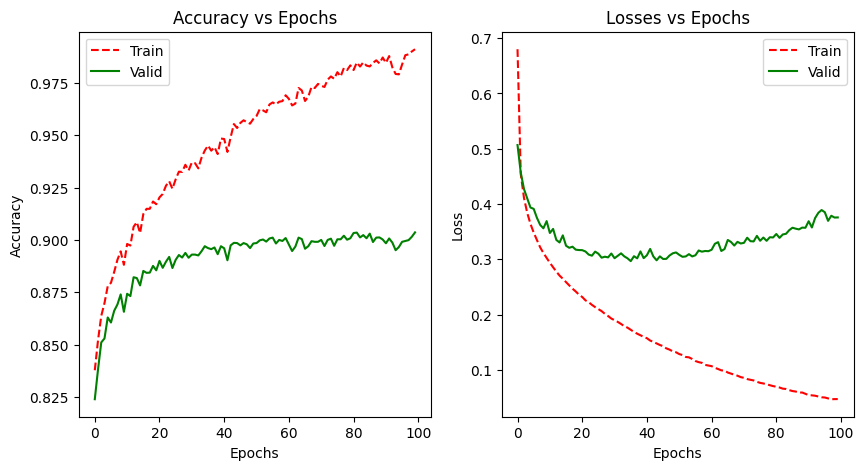

In [23]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

### Learning Rate = 0.00001

In [24]:
epochs = 100
learning_rate = 1e-05
train_losses, train_accuracies, valid_losses, valid_accuracies = train(epochs, learning_rate)

********** EPOCH  0/99 **********
#################################
Train Loss: 1.408, Train Accuracy: 72.20
Valid Loss: 0.946, Valid Accuracy: 71.04
#################################
********** EPOCH  1/99 **********
#################################
Train Loss: 0.808, Train Accuracy: 76.96
Valid Loss: 0.737, Valid Accuracy: 75.63
#################################
********** EPOCH  2/99 **********
#################################
Train Loss: 0.674, Train Accuracy: 79.02
Valid Loss: 0.652, Valid Accuracy: 77.87
#################################
********** EPOCH  3/99 **********
#################################
Train Loss: 0.608, Train Accuracy: 80.79
Valid Loss: 0.604, Valid Accuracy: 79.66
#################################
********** EPOCH  4/99 **********
#################################
Train Loss: 0.566, Train Accuracy: 81.84
Valid Loss: 0.571, Valid Accuracy: 80.85
#################################
********** EPOCH  5/99 **********
#################################
Train Loss: 

#################################
Train Loss: 0.343, Train Accuracy: 88.05
Valid Loss: 0.391, Valid Accuracy: 86.40
#################################
********** EPOCH 46/99 **********
#################################
Train Loss: 0.342, Train Accuracy: 88.16
Valid Loss: 0.386, Valid Accuracy: 86.32
#################################
********** EPOCH 47/99 **********
#################################
Train Loss: 0.340, Train Accuracy: 88.23
Valid Loss: 0.384, Valid Accuracy: 86.48
#################################
********** EPOCH 48/99 **********
#################################
Train Loss: 0.338, Train Accuracy: 88.29
Valid Loss: 0.383, Valid Accuracy: 86.53
#################################
********** EPOCH 49/99 **********
#################################
Train Loss: 0.337, Train Accuracy: 88.28
Valid Loss: 0.384, Valid Accuracy: 86.63
#################################
********** EPOCH 50/99 **********
#################################
Train Loss: 0.336, Train Accuracy: 88.36
Valid

#################################
Train Loss: 0.290, Train Accuracy: 89.88
Valid Loss: 0.350, Valid Accuracy: 87.63
#################################
********** EPOCH 91/99 **********
#################################
Train Loss: 0.289, Train Accuracy: 89.91
Valid Loss: 0.350, Valid Accuracy: 87.77
#################################
********** EPOCH 92/99 **********
#################################
Train Loss: 0.288, Train Accuracy: 89.86
Valid Loss: 0.351, Valid Accuracy: 87.61
#################################
********** EPOCH 93/99 **********
#################################
Train Loss: 0.287, Train Accuracy: 89.93
Valid Loss: 0.349, Valid Accuracy: 87.81
#################################
********** EPOCH 94/99 **********
#################################
Train Loss: 0.286, Train Accuracy: 89.96
Valid Loss: 0.349, Valid Accuracy: 87.71
#################################
********** EPOCH 95/99 **********
#################################
Train Loss: 0.285, Train Accuracy: 90.00
Valid

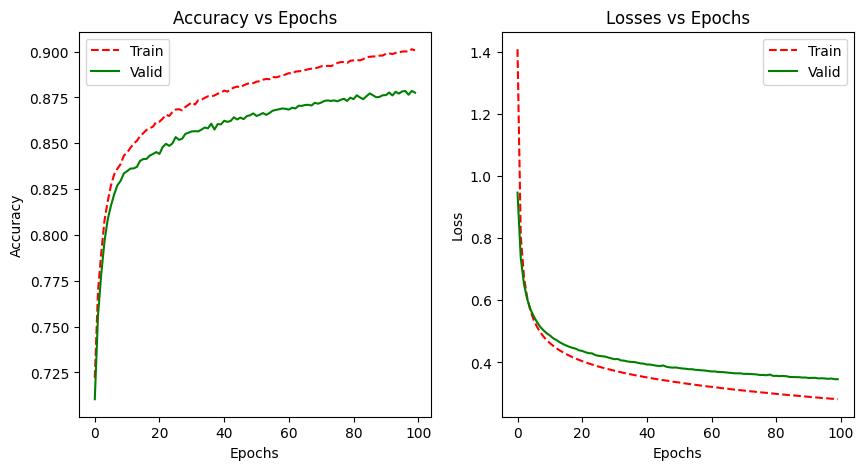

In [25]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

NOTE: Learning rate > 0.00